In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer

In [43]:
data = pd.read_csv('/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Codes/kMC ordenado/data.csv')
data = data.drop(['Unnamed: 10'], axis=1)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Fuente(experimento)'] = data.index.astype(str) + '_' + data['Fuente'] + ' (' + data['Experimento'] + ')'
data = data.drop(['Fuente','Experimento'], axis=1)
data.insert(0, 'T0', 0)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,Fuente(experimento)
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587,0_Adsorcion de As+5 Espana ( 60ppmSb-As)
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691,1_Adsorcion de As+5 Espana ( 60ppmAs-As)
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964,2_Adsorcion de As+5 Espana ( 90ppmAs-As)
3,0,1.145313,1.696100,2.264219,3.106472,3.699600,4.016499,4.056284,4.106165,3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360,4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871,5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965,6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876,7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996,8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952,9_Adsorcion de Sb Espana ( 120ppmSb-Sb)


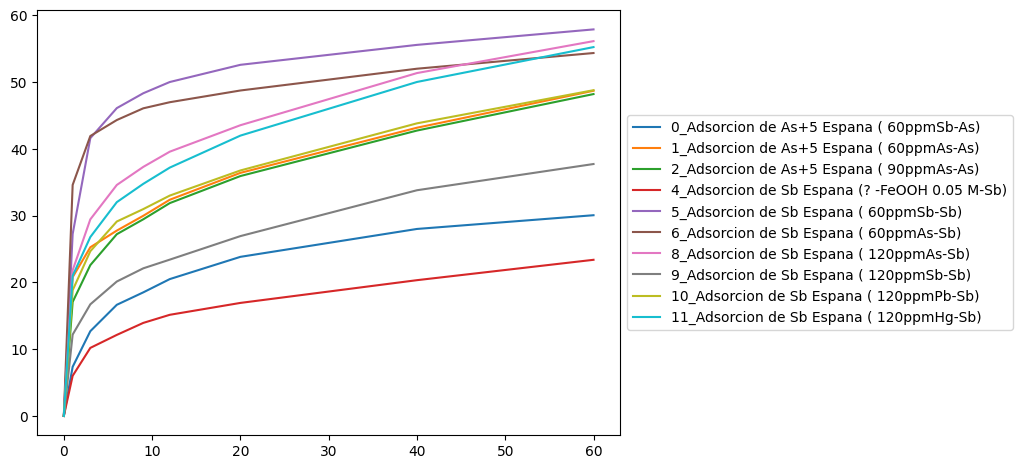

In [44]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

for i in range(len(data)):
    if i != 3 and i != 7:
        valores_numericos = pd.to_numeric(data.iloc[i], errors='coerce').dropna()
        etiqueta = data.iloc[i]['Fuente(experimento)']
        plt.plot(time_array, valores_numericos.values, label=etiqueta)

plt.legend()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        

In [97]:
import numpy as np

class KineticMonteCarlo:
    def __init__(self, lattice_size, T, processes, time_array, time_factor = 1e-7):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.processes = processes  # dict: procesos y sus parámetros
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {p: 0 for p in processes.keys()}
        self.events_history = {p: [] for p in processes.keys()}

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def calculate_transition_rates(self, site):
        rates = {}
        n_ij = self.count_occupied_neighbors(site)

        if "adsorption" in self.processes:
            e_ads = self.processes["adsorption"]["e_ads"]
            e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
            E_ads = e_int_abs * n_ij + e_ads
            k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
            rates["adsorption"] = k_ads

        if "desorption" in self.processes:
            e_des = self.processes["desorption"]["e_des"]
            e_int_des = self.processes["desorption"].get("e_int_des", 0)
            E_des = e_int_des * n_ij + e_des
            k_des = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
            rates["desorption"] = k_des

        if "diffusion" in self.processes:
            e_diff = self.processes["diffusion"]["e_diff"]
            k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-e_diff / (self.k_b * self.T))
            rates["diffusion"] = k_diff

        return rates

    def select_event(self, rates):
        total_propensity = sum(rates.values())
        r = np.random.rand() * total_propensity
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None  # shouldn't happen

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            if not rates or sum(rates.values()) == 0:
                break  # No more events possible

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event_type = self.select_event(rates)
            if event_type == "adsorption":
                self.lattice[site] = 1
            elif event_type == "desorption" and self.lattice[site] == 1:
                self.lattice[site] = 0
            elif event_type == "diffusion":
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.events_count[event_type] += 1
            for key in self.events_history:
                self.events_history[key].append(self.events_count[key])

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

        return self.occupancy
    
    def reset_lattice(self):
        self.lattice = np.zeros((self.lattice_size, self.lattice_size))
        self.occupancy = {t: None for t in self.time_array} 



In [98]:
class KMCModelOptimizer:
    def __init__(self, exp_data, param_ranges, n_calls=200):
        self.exp_data = exp_data
        self.param_ranges = param_ranges
        self.n_calls = n_calls
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = tqdm(total=self.n_calls, desc="Optimización Bayesiana en Progreso", position=0, ncols=100)

    def loss_function(self, params):
        # Desempaquetar parámetros de acuerdo a lo que se pasa
        param_dict = {}
        param_names = list(self.param_ranges.keys())

        for i, param_name in enumerate(param_names):
            param_dict[param_name] = params[i]

        # Construir el diccionario de procesos
        processes = {}
        if 'e_ads' in param_dict:
            processes["adsorption"] = {"e_ads": param_dict["e_ads"], "e_int_abs": param_dict.get("e_int_abs", 0.1)}
        if 'e_des' in param_dict:
            processes["desorption"] = {"e_des": param_dict["e_des"], "e_int_des": param_dict.get("e_int_des", 0.7)}
        if 'e_diff' in param_dict:
            processes["diffusion"] = {"e_diff": param_dict["e_diff"]}

        # Ejecutar el modelo KMC
        kmc_model = KineticMonteCarlo(
            lattice_size=int(param_dict['lattice_size']), T=param_dict['T'],
            processes=processes,
            time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
        )

        kmc_model.reset_lattice()
        kmc_model.run_simulation()

        # Calcular error
        simulated_data = np.array(list(kmc_model.occupancy.values()))
        error = np.mean((simulated_data - self.exp_data) ** 2)

        # Actualizar mejores parámetros si se encuentra un menor error
        if error < self.best_error:
            self.best_error = error
            self.best_params = param_dict

        # Actualizar la barra de progreso con información relevante
        self.progress_bar.set_postfix({
            "Mejor error": f"{self.best_error:.6f}",
            "Parámetros óptimos": f"{self.best_params}",
            "Progreso": f"{self.progress_bar.n}/{self.progress_bar.total}"
        })
        self.progress_bar.update(1)

        return error

    def optimize(self):
        # Definir el espacio de búsqueda dinámicamente solo con los parámetros presentes
        space = []
        param_names = list(self.param_ranges.keys())

        for param_name in param_names:
            if param_name == 'e_ads' and 'e_ads' in self.param_ranges:
                space.append(Real(self.param_ranges['e_ads'][0], self.param_ranges['e_ads'][1], name="e_ads"))
            elif param_name == 'e_des' and 'e_des' in self.param_ranges:
                space.append(Real(self.param_ranges['e_des'][0], self.param_ranges['e_des'][1], name="e_des"))
            elif param_name == 'e_diff' and 'e_diff' in self.param_ranges:
                space.append(Real(self.param_ranges['e_diff'][0], self.param_ranges['e_diff'][1], name="e_diff"))
            elif param_name == 'e_int_abs' and 'e_int_abs' in self.param_ranges:
                space.append(Real(self.param_ranges['e_int_abs'][0], self.param_ranges['e_int_abs'][1], name="e_int_abs"))
            elif param_name == 'e_int_des' and 'e_int_des' in self.param_ranges:
                space.append(Real(self.param_ranges['e_int_des'][0], self.param_ranges['e_int_des'][1], name="e_int_des"))
            elif param_name == 'lattice_size' and 'lattice_size' in self.param_ranges:
                space.append(Integer(self.param_ranges['lattice_size'][0], self.param_ranges['lattice_size'][1], name="lattice_size"))
            elif param_name == 'T' and 'T' in self.param_ranges:
                space.append(Real(self.param_ranges['T'][0], self.param_ranges['T'][1], name="T"))

        # Iniciar optimización
        start_time = time.time()
        result = gp_minimize(self.loss_function, space, n_calls=self.n_calls, random_state=42)
        self.progress_bar.close()

        # Mostrar resultados finales
        end_time = time.time()
        print("\n✅ Optimización completada")
        print("🔹 Parámetros óptimos encontrados:", self.best_params)
        print("🔹 Error mínimo encontrado:", self.best_error)
        print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")
        
        # Pasar los mejores parámetros al modelo KMC
        self.run_kmc_with_best_params()

    def run_kmc_with_best_params(self):
        if self.best_params:
            # Construir el diccionario de procesos con los mejores parámetros
            processes = {}
            if 'e_ads' in self.best_params:
                processes["adsorption"] = {"e_ads": self.best_params["e_ads"], "e_int_abs": self.best_params.get("e_int_abs", 0.1)}
            if 'e_des' in self.best_params:
                processes["desorption"] = {"e_des": self.best_params["e_des"], "e_int_des": self.best_params.get("e_int_des", 0.7)}
            if 'e_diff' in self.best_params:
                processes["diffusion"] = {"e_diff": self.best_params["e_diff"]}

            # Crear el modelo KMC con los mejores parámetros encontrados
            kmc_model = KineticMonteCarlo(
                lattice_size=int(self.best_params['lattice_size']), T=self.best_params['T'],
                processes=processes,
                time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
            )

            # Ejecutar la simulación con los mejores parámetros
            kmc_model.run_simulation()
            print(f"Modelo KMC ejecutado con los mejores parámetros: {self.best_params}")
        else:
            print("No se encontraron parámetros óptimos para ejecutar el modelo KMC.")


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def run_multiple_simulations(N, lattice_size, T, processes, time_array, exp_data):
    curves = []
    times = []

    for _ in range(N):
        kmc_model = KineticMonteCarlo(
            lattice_size=lattice_size, 
            T=T, 
            processes=processes,  # El diccionario de procesos se pasa tal cual
            time_array=time_array
        )
        kmc_model.reset_lattice()
        occupancy = kmc_model.run_simulation()
        curves.append(list(occupancy.values()))
        times.append(kmc_model.time_array)
    
    # Convertir a DataFrame para facilitar el procesamiento
    df = pd.DataFrame(curves)
    
    # Calcular media y desviación estándar
    mean_values = df.mean().to_numpy()
    std_values = df.std().to_numpy()

    # Imprimir valores medios y desviación estándar
    print("Mean values: ", mean_values)
    print("Standard deviation values: ", std_values)

    # Graficar los resultados
    plt.errorbar(time_array, mean_values, yerr=std_values, capsize=5, color='red', fmt='o', label='Mean values')
    plt.plot(time_array, exp_data, marker='o', label='Experimental data')
    plt.xlabel("Time")
    plt.ylabel("Percentage of occupied sites")
    plt.title("Adsorption over time")
    plt.legend()

    # Calcular el Error Cuadrático Medio (MSE)
    mse = np.mean((np.array(exp_data) - np.array(mean_values)) ** 2)
    print(f"Mean Squared Error (MSE): {mse}")


### ***Test considerando todos los procesos***

```python

lattice_size = 70
T = 280
e_ads = -1.83
e_des = 1.23
e_diff = -0.579
e_int_abs = 0.8
e_int_des = 0.7
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

In [100]:
# Datos experimentales
exp_data = data.iloc[8, :9].to_numpy()

# Definir porcentaje de variabilidad
variability_percentage = 0.1  # 10% de variabilidad

# Valores centrales del proceso (basado en los valores proporcionados)
processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.07},
    "desorption": {"e_des": 0.1, "e_int_des": 0.7},
    "diffusion": {"e_diff": 0.36}
}

# Calcular los rangos de parámetros con un 10% de variabilidad
param_ranges = {
    'e_ads': [processes["adsorption"]["e_ads"] * (1 - variability_percentage), processes["adsorption"]["e_ads"] * (1 + variability_percentage)],
    'e_des': [processes["desorption"]["e_des"] * (1 - variability_percentage), processes["desorption"]["e_des"] * (1 + variability_percentage)],
    'e_diff': [processes["diffusion"]["e_diff"] * (1 - variability_percentage), processes["diffusion"]["e_diff"] * (1 + variability_percentage)],
    'e_int_abs': [processes["adsorption"]["e_int_abs"] * (1 - variability_percentage), processes["adsorption"]["e_int_abs"] * (1 + variability_percentage)],
    'e_int_des': [processes["desorption"]["e_int_des"] * (1 - variability_percentage), processes["desorption"]["e_int_des"] * (1 + variability_percentage)],
    'lattice_size': [50, 100], # Tamaño de la rejilla
    'T': [280, 350]           # Temperatura en el rango especificado
}

# Ejecutar la optimización
optimizer = KMCModelOptimizer(exp_data, param_ranges, n_calls=100)
optimizer.optimize()



Optimización Bayesiana en Progreso: 100%|█| 100/100 [00:54<00:00,  1.83it/s, Mejor error=0.223202, P


✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.09547621728154916, 'e_des': 0.09605860638826624, 'e_diff': 0.37260583764922534, 'e_int_abs': 0.06390418455795775, 'e_int_des': 0.77, 'lattice_size': np.int64(90), 'T': 301.77705330141544}
🔹 Error mínimo encontrado: 0.22320228805789752
⏳ Tiempo total de ejecución: 54.54 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.09547621728154916, 'e_des': 0.09605860638826624, 'e_diff': 0.37260583764922534, 'e_int_abs': 0.06390418455795775, 'e_int_des': 0.77, 'lattice_size': np.int64(90), 'T': 301.77705330141544}


In [101]:
e_ads = optimizer.best_params['e_ads']
e_des = optimizer.best_params['e_des']
e_diff = optimizer.best_params['e_diff']
e_int_abs = optimizer.best_params['e_int_abs']
e_int_des = optimizer.best_params['e_int_des']
lattice_size = optimizer.best_params['lattice_size']
T = optimizer.best_params['T']

{'adsorption': 7085, 'desorption': 1391, 'diffusion': 95}


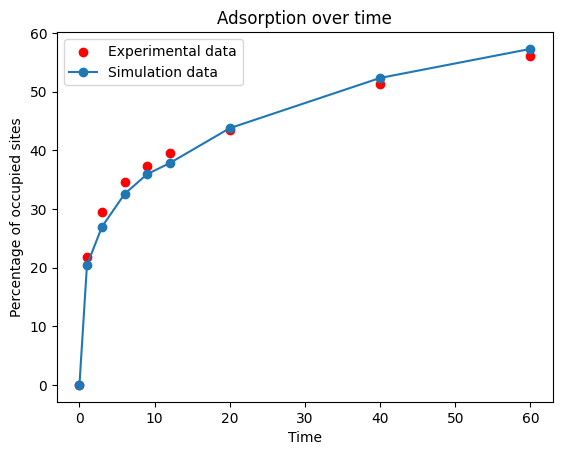

Mean Squared Error (MSE): 2.1873048009167095


In [113]:
processes = {
    "adsorption": {"e_ads": e_ads, "e_int_abs": e_int_abs},
    "desorption": {"e_des": e_des, "e_int_des": e_int_des},
    "diffusion": {"e_diff": e_diff}
}
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])


sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
sim.reset_lattice()
result = sim.run_simulation()


print(sim.events_count)

simulated_data = result.values()
plt.scatter(time_array, data.iloc[8, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((data.iloc[8, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

Mean values:  [ 0.         20.53444444 27.86888889 33.37728395 37.04135802 39.76790123
 44.93555556 52.49753086 57.2917284 ]
Standard deviation values:  [0.         1.58181107 1.68395543 1.43132488 1.45222958 1.41114465
 1.12943091 0.92579124 0.81425091]
Mean Squared Error (MSE): 1.152889695542824


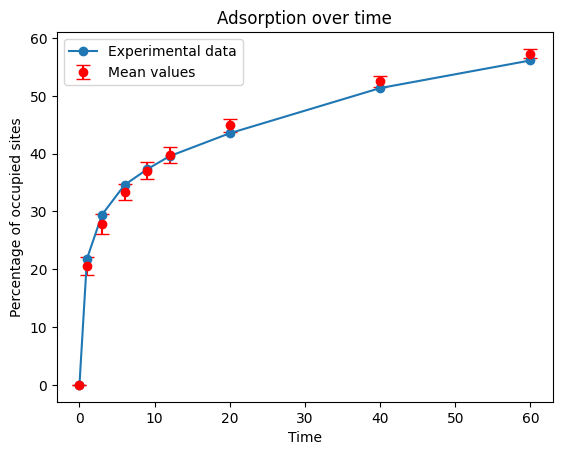

In [115]:
N = 100
run_multiple_simulations(N, lattice_size, T, processes, time_array, data.iloc[8, :9].to_numpy())

### ***Test sin desorción***

```python

lattice_size = 70
T = 300
e_ads = 0.09
e_diff = 0.294
e_int_abs = 0.1
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

In [116]:
# Datos experimentales
exp_data = data.iloc[8, :9].to_numpy()

# Definir porcentaje de variabilidad
variability_percentage = 0.3  # 10% de variabilidad

# Valores centrales del proceso (basado en los valores proporcionados)
processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.1},
    "diffusion": {"e_diff": 0.294}
}

# Calcular los rangos de parámetros con un 10% de variabilidad
param_ranges = {
    'e_ads': [processes["adsorption"]["e_ads"] * (1 - variability_percentage), processes["adsorption"]["e_ads"] * (1 + variability_percentage)],
    'e_diff': [processes["diffusion"]["e_diff"] * (1 - variability_percentage), processes["diffusion"]["e_diff"] * (1 + variability_percentage)],
    'e_int_abs': [processes["adsorption"]["e_int_abs"] * (1 - variability_percentage), processes["adsorption"]["e_int_abs"] * (1 + variability_percentage)],
    'lattice_size': [50, 100], # Tamaño de la rejilla
    'T': [280, 350]           # Temperatura en el rango especificado
}

# Ejecutar la optimización
optimizer = KMCModelOptimizer(exp_data, param_ranges,100)
optimizer.optimize()

Optimización Bayesiana en Progreso: 100%|█| 100/100 [01:00<00:00,  1.65it/s, Mejor error=0.304007, P


✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.07515477597720441, 'e_diff': 0.3339870161092152, 'e_int_abs': 0.08272612857045246, 'lattice_size': np.int64(69), 'T': 295.065564066078}
🔹 Error mínimo encontrado: 0.304006853178058
⏳ Tiempo total de ejecución: 60.60 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.07515477597720441, 'e_diff': 0.3339870161092152, 'e_int_abs': 0.08272612857045246, 'lattice_size': np.int64(69), 'T': 295.065564066078}


In [117]:
e_ads = optimizer.best_params['e_ads']
e_diff = optimizer.best_params['e_diff']
e_int_abs = optimizer.best_params['e_int_abs']
lattice_size = optimizer.best_params['lattice_size']
T = optimizer.best_params['T']

{'adsorption': 3894, 'diffusion': 377}


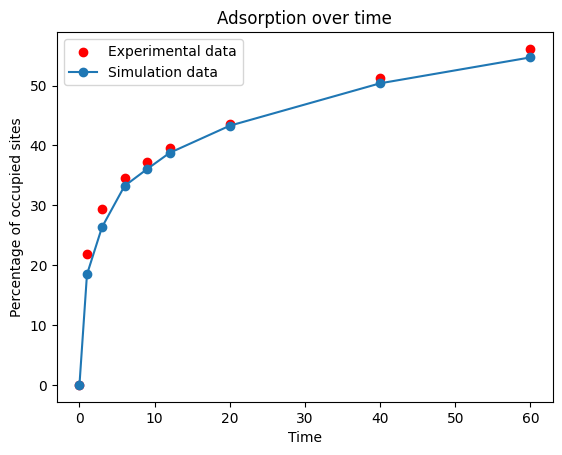

Mean Squared Error (MSE): 3.1089484497392577


In [118]:
processes = {
    "adsorption": {"e_ads": e_ads, "e_int_abs": e_int_abs},
    "diffusion": {"e_diff": e_diff}
}
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size=lattice_size, T=T, processes=processes, time_array=time_array)
sim.reset_lattice()
result = sim.run_simulation()

print(sim.events_count)

simulated_data = result.values()
plt.scatter(time_array, data.iloc[8, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((data.iloc[8, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

Mean values:  [ 0.         21.13967654 28.0978786  33.35538752 36.69481201 39.39025415
 44.31905062 51.352657   55.59462298]
Standard deviation values:  [0.         1.88110139 1.57088616 1.30740565 1.22740372 1.15840968
 1.00942159 0.86668797 0.77939516]
Mean Squared Error (MSE): 0.5570705280991131


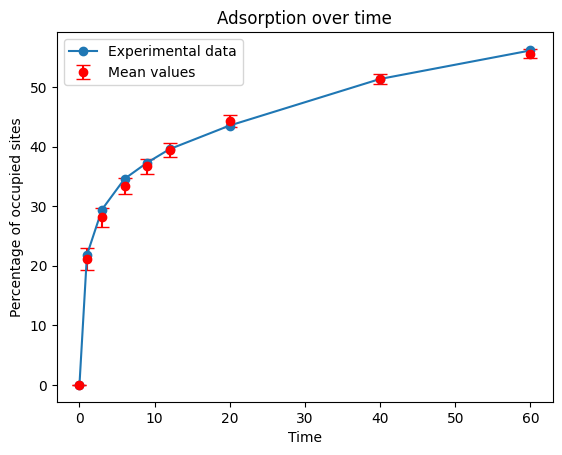

In [119]:
N = 100
run_multiple_simulations(N, lattice_size, T, processes, time_array, data.iloc[8, :9].to_numpy())

### ***Test solo con adsorción***

```python

lattice_size = 70
T = 300
e_ads = 0.09
e_int_abs = 0.1
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

In [120]:
# Datos experimentales
exp_data = data.iloc[8, :9].to_numpy()

# Definir porcentaje de variabilidad
variability_percentage = 0.3  # 10% de variabilidad

# Valores centrales del proceso (basado en los valores proporcionados)
processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.1},
}

# Calcular los rangos de parámetros con un 10% de variabilidad
param_ranges = {
    'e_ads': [processes["adsorption"]["e_ads"] * (1 - variability_percentage), processes["adsorption"]["e_ads"] * (1 + variability_percentage)],
    'e_int_abs': [processes["adsorption"]["e_int_abs"] * (1 - variability_percentage), processes["adsorption"]["e_int_abs"] * (1 + variability_percentage)],
    'lattice_size': [50, 100], # Tamaño de la rejilla
    'T': [280, 350]           # Temperatura en el rango especificado
}

# Ejecutar la optimización
optimizer = KMCModelOptimizer(exp_data, param_ranges,100)
optimizer.optimize()

Optimización Bayesiana en Progreso: 100%|█| 100/100 [00:43<00:00,  2.29it/s, Mejor error=0.266880, P


✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.09864611967654231, 'e_int_abs': 0.07134432635895016, 'lattice_size': np.int64(100), 'T': 330.38996333708485}
🔹 Error mínimo encontrado: 0.2668803673916852
⏳ Tiempo total de ejecución: 43.64 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.09864611967654231, 'e_int_abs': 0.07134432635895016, 'lattice_size': np.int64(100), 'T': 330.38996333708485}


In [121]:
e_ads = optimizer.best_params['e_ads']
e_int_abs = optimizer.best_params['e_int_abs']
lattice_size = optimizer.best_params['lattice_size']
T = optimizer.best_params['T']

{'adsorption': 7854}


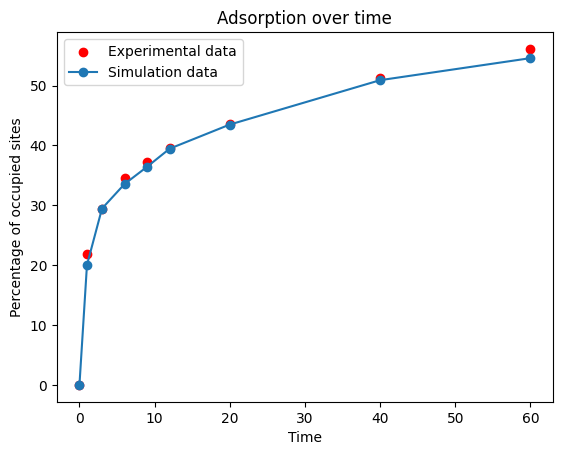

Mean Squared Error (MSE): 0.8452623623472442


In [122]:
processes = {
    "adsorption": {"e_ads": e_ads, "e_int_abs": e_int_abs},
}
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size=lattice_size, T=T, processes=processes, time_array=time_array)
sim.reset_lattice()
result = sim.run_simulation()

print(sim.events_count)

simulated_data = result.values()
plt.scatter(time_array, data.iloc[8, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((data.iloc[8, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

Mean values:  [ 0.     22.4876 29.5343 34.6443 37.867  40.2295 44.8045 51.6532 55.8543]
Standard deviation values:  [0.         1.96049011 1.36711024 1.21859685 1.30347205 1.28549906
 1.09673195 0.92172969 0.73031784]
Mean Squared Error (MSE): 0.33951691939435913


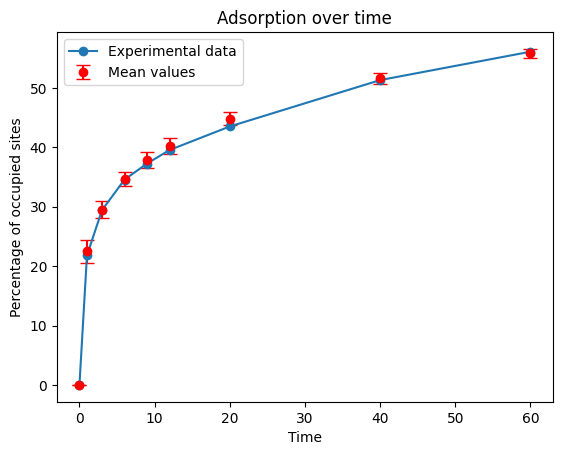

In [123]:
N = 100
run_multiple_simulations(N, lattice_size, T, processes, time_array, data.iloc[8, :9].to_numpy())

### ***Test sin difusión***

```python

lattice_size = 70
T = 280
e_ads = -1.83
e_des = 1.23
e_int_abs = 0.8
e_int_des = 0.7
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

In [124]:
# Datos experimentales
exp_data = data.iloc[8, :9].to_numpy()

# Definir porcentaje de variabilidad
variability_percentage = 0.1  # 10% de variabilidad

# Valores centrales del proceso (basado en los valores proporcionados)
processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.07},
    "desorption": {"e_des": 0.1, "e_int_des": 0.7}
}

# Calcular los rangos de parámetros con un 10% de variabilidad
param_ranges = {
    'e_ads': [processes["adsorption"]["e_ads"] * (1 - variability_percentage), processes["adsorption"]["e_ads"] * (1 + variability_percentage)],
    'e_des': [processes["desorption"]["e_des"] * (1 - variability_percentage), processes["desorption"]["e_des"] * (1 + variability_percentage)],
    'e_int_abs': [processes["adsorption"]["e_int_abs"] * (1 - variability_percentage), processes["adsorption"]["e_int_abs"] * (1 + variability_percentage)],
    'e_int_des': [processes["desorption"]["e_int_des"] * (1 - variability_percentage), processes["desorption"]["e_int_des"] * (1 + variability_percentage)],
    'lattice_size': [50, 100], # Tamaño de la rejilla
    'T': [280, 350]           # Temperatura en el rango especificado
}

# Ejecutar la optimización
optimizer = KMCModelOptimizer(exp_data, param_ranges, n_calls=100)
optimizer.optimize()



Optimización Bayesiana en Progreso: 100%|█| 100/100 [00:54<00:00,  1.82it/s, Mejor error=0.289680, P


✅ Optimización completada
🔹 Parámetros óptimos encontrados: {'e_ads': 0.081, 'e_des': 0.10999872510203206, 'e_int_abs': 0.06825157192074086, 'e_int_des': 0.77, 'lattice_size': np.int64(100), 'T': 306.353907076183}
🔹 Error mínimo encontrado: 0.2896799361472397
⏳ Tiempo total de ejecución: 54.81 segundos
Modelo KMC ejecutado con los mejores parámetros: {'e_ads': 0.081, 'e_des': 0.10999872510203206, 'e_int_abs': 0.06825157192074086, 'e_int_des': 0.77, 'lattice_size': np.int64(100), 'T': 306.353907076183}


In [125]:
e_ads = optimizer.best_params['e_ads']
e_des = optimizer.best_params['e_des']
e_int_abs = optimizer.best_params['e_int_abs']
e_int_des = optimizer.best_params['e_int_des']
lattice_size = optimizer.best_params['lattice_size']
T = optimizer.best_params['T']

{'adsorption': 8276, 'desorption': 695}


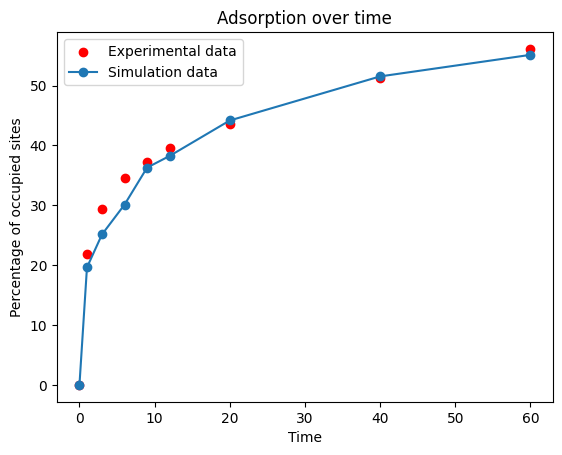

Mean Squared Error (MSE): 5.273689984902798


In [126]:
processes = {
    "adsorption": {"e_ads": e_ads, "e_int_abs": e_int_abs},
    "desorption": {"e_des": e_des, "e_int_des": e_int_des},
}
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size = lattice_size, T=T, processes=processes, time_array=time_array)
result = sim.run_simulation()


print(sim.events_count)

simulated_data = result.values()
plt.scatter(time_array, data.iloc[8, :9].to_numpy(),color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((data.iloc[8, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

Mean values:  [ 0.     22.0534 28.725  33.8277 37.1446 39.5101 44.1809 51.0273 55.287 ]
Standard deviation values:  [0.         1.87928861 1.68514694 1.50417859 1.37254053 1.28880298
 1.11284247 0.9031246  0.83986832]
Mean Squared Error (MSE): 0.2607026410343529


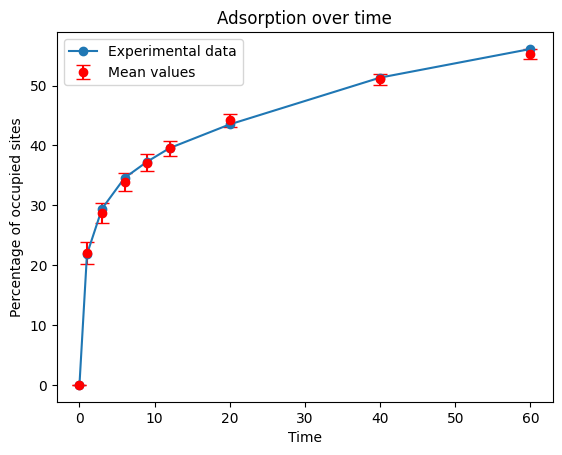

In [127]:
N = 100
run_multiple_simulations(N, lattice_size, T, processes, time_array, data.iloc[8, :9].to_numpy())

## Consideraciones

- Considerar interacciones de mayor alcance (No solo a primeros vecinos)
- Considerar otro tipo de interacción entre vecinos que la dependencia con la cantidad de primeros vecinos no sea lineal
- Considerar una PES base para el adorbente según alguna geometría 
- La energía de difusión puede depender del entorno local
- Para hacer la optimización más robusta contra la estocasticidad inherente de KMC, modifique la función loss_function para usar el promedio de múltiples ejecuciones KMC (de manera similar a su función run_multiple_simulations) para cada conjunto de parámetros evaluado. Aunque es computacionalmente más costoso, esto puede llevar a parámetros óptimos más confiables.
- Considere la interacción para difusión donde el peso por número de vecinos dependa tanto del número de vecinos actuales y el número de vecinos del sitio a donde se puede trasladar
- Considerar la optimización por lotes de simulaciones y basándose en el promedio del lote para cada punto
- Vectorizar el modelo
- Es necesario encontrar el rango apropiado para los parámetros en cada caso. Este problema juega en contra de la automatización del algoritmo. Porque a partir de la variabilidad solamente se arriesga que caiga el modelo caiga en conjuntos de parámetros que hagan tardía la simulación. Los valores iniciales de los parámetros es fundamental
- Hay que revisar a fondo el optimizador hay cosas que no tienen sentido

Simulaciones KMC Manuales (Análisis de Sensibilidad):

Realiza unas pocas simulaciones KMC variando un parámetro a la vez, manteniendo los otros fijos en valores estimados iniciales (de la literatura o intuición).
Observa cómo cambia la curva simulada:
¿Qué parámetro afecta más la pendiente inicial? (Probablemente e_ads).
¿Qué parámetro afecta más el nivel de saturación? (e_ads, e_des, lattice_size, interacciones repulsivas).
¿Qué parámetro afecta la "curvatura" o forma? (Interacciones e_int).
Esto te dará una idea de qué rangos son más probables para cada parámetro para reproducir las características cualitativas de tus datos experimentales.


## Para tener en cuenta en la próxima version

- Considerar redes grandes garantiza estabilidad y poca variabilidad en la simualción. Pero también significa gasto computacional. 
- Considerar esa redes grandes permite hacer mejores ajustes
- Creo que hay que aprender a mover los paármetros de desorción y difusión. Tal vez agregarle un parámetro de interacción a la energía de difusión
- Hay que preguntarle a cesar si los procesos están disponibles siempre. Porque puede que haya tiempos para todo y que hayan fases del proceso global. Como que primero adsorbe luego desorbe y la difusióne. Y ciertos procesos son más probables en ciertos insatntes de tiempo.
- Hay que revisar lo que hacen los procesos de desorción y difusión en el modelo, parece que no cumplen con su función
- Los casos en los que no ajusta bien hay que revisar que pasa con los parámetros. Y como se involucran los demas
- Se pueden generar graficos de adsorción, desorsión y difusión en el tiempo. pero hay que pensarlos bien no es simplmente contarlos creería